# TP Coding a GAN in tensorflow/keras

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist and cifar10 datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D,LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

## Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:
def load_data(dataset_name):
  # Load the dataset
  if(dataset_name == 'mnist'):
    (X_train, _), (_, _) = mnist.load_data()
  elif(dataset_name == 'cifar'):
    from keras.datasets import cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
  else:
    print('Error, unknown database')

  # Rescale -1 to 1
  X_train = X_train / 127.5 - 1.
  #add a channel dimension, if need be (for mnist data)
  if(X_train.ndim ==3):
    X_train = np.expand_dims(X_train, axis=3)
  return X_train
		

## Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [3]:
def build_generator(z_dim,img_shape,dataset_name):

  z_rand = Input(shape=(z_dim,))
  # BEGIN FILL IN CODE
  x= Dense(256,)(z_rand)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dense(256,)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dense(784,)(x)
  x=tf.keras.activations.tanh(x)
  output_img=Reshape((28,28,1))(x)
  # END FILL IN CODE
  model_generator = Model(z_rand, output_img)
  model_generator.summary()

  return model_generator


In [4]:

def build_discriminator(img_shape,dataset_name):

  input_img = Input(shape=img_shape)
	
  # BEGIN FILL IN CODE
  x=Flatten()(input_img)
  x=Dense(512,)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dense(256,)(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dense(1,activation='sigmoid')(x)
  p_true=x
 
  # END FILL IN CODE

  model_discriminator = Model(input_img, p_true)
  model_discriminator.summary()

  return model_discriminator


## Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-G(z)))$

You can use the ```k.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train generator on fake images $G(z)$



In [5]:

optimizer = Adam(0.0002, 0.5)
dataset_name = 'mnist'
X_train = load_data(dataset_name)

# default parameters for mnist 
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
img_channels = X_train.shape[3]
img_shape = (img_rows, img_cols, img_channels)
z_dim = 10

# Build and compile the discriminator
discriminator = build_discriminator(img_shape,dataset_name)
# set discriminator loss
discriminator.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy']) # FILL IN CODE

# Build the generator
generator = build_generator(z_dim,img_shape,dataset_name)

# Create the stacked model
#first, create the random vector z in the latent space
z = Input(shape=(z_dim,))
#create generated (fake) image
gen_img = generator(z)  # FILL IN CODE

#indicate that for the stacked model, the weights are not trained (we only train the generator in the stacked model)
discriminator.trainable = False

# The discriminator takes generated images as input and gives a probability of whether it is a true or false image
p_true = discriminator(gen_img)  # FILL IN CODE

# The combined model  (stacked generator and discriminator)
# In this model, we train the generator only
stacked_gen_disc = Model(z, p_true)

# generator loss
generator_loss = K.mean(K.log(1-p_true))  # FILL IN CODE
# create stacked model loss
stacked_gen_disc.add_loss(generator_loss)
stacked_gen_disc.compile(optimizer=optimizer)

	

11501568/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                              

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [6]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = np.random.normal(0, 1, (r * c, z_dim))
  gen_imgs = generator.predict(z_random)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        axs[i,j].imshow(gen_imgs[cnt, :,:])
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train generator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

In [7]:
# parameters for training
batch_size=64
n_iters_outer=10000
sample_interval=100
n_iters_inner=1	#number of internal loops

#load dataset
X_train = load_data(dataset_name)

# Adversarial ground truths
d_output_true = np.ones((batch_size,1))  #FILL IN CODE
d_output_false = np.zeros((batch_size,1)) #FILL IN CODE

# start training 
for iter_outer in range(0,n_iters_outer):

  # ---------------------
  #  Train Discriminator
  # ---------------------

  # Train the discriminator
  for iter_inner in range(0,n_iters_inner):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z_random = np.random.normal(0, 1, (batch_size, z_dim))

    # Generate a batch of new (fake) images
    gen_imgs = generator.predict(z_random)
    #print(gen_imgs)
    d_loss_real = discriminator.train_on_batch(imgs, d_output_true)  # FILL IN CODE
    d_loss_fake = discriminator.train_on_batch(gen_imgs, d_output_false) # FILL IN CODE
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  # ---------------------
  #  Train Generator
  # ---------------------


  z_random = np.random.normal(0, 1, (batch_size, z_dim))

  # Generator training : try to make generated images be classified as true by the discriminator
  g_loss = stacked_gen_disc.train_on_batch(z_random)

  # Save some random generated images and the models at every sample_interval iterations
  if (iter_outer % sample_interval == 0):
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter_outer, d_loss[0], 100*d_loss[1], g_loss))
    sample_images(generator,z_dim, rand_seed=30)

Output hidden; open in https://colab.research.google.com to view.

## Interpolation in the latent space 

Very often, we wish to not only generate samples, but also _interpolate_ between two codes in the latent space (for example, interpolating between a boot and a shoe, as seen in the lesson).

In this part, we will carry out this interpolation, and see what sort of intermediate results are produced.

First of all, draw two samples in the latent space such that the generated images are realistic enough (you can try different ones changing the seed of the random number generator).

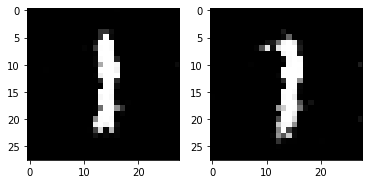

In [8]:
# FILL IN CODE
z_random = np.random.normal(0, 1, (2, z_dim))
gen_imgs = generator.predict(z_random)
gen_imgs=0.5*gen_imgs+0.5 #rescaling
fig,axs = plt.subplots(1,2)
axs[0].imshow(gen_imgs[0, :,:,0], cmap='gray')
axs[1].imshow(gen_imgs[1, :,:,0], cmap='gray')

Now, interpolate between the two codes, using 10 steps, and show the intermediate results.

In [9]:
# FILL IN CODE
p1=z_random[0]
p2=z_random[1]
s= np.linspace(0,1,num=10)
v=[]
for p in s :
  vect= (1-p)*p1+p*p2
  v.append(vect)
print(v)
gen_imgs=generator.predict(np.array(v))
print(gen_imgs.shape)
gen_imgs=0.5*gen_imgs+0.5 #rescaling

[array([ 0.41514214,  0.55381169, -0.26616234,  2.19680258,  0.0438125 ,
       -1.58723185,  1.09714524,  1.20216848,  2.11769791, -1.31995997]), array([ 0.34107505,  0.64990337, -0.18216636,  2.14713743,  0.20089685,
       -1.34876094,  1.02187542,  1.07646538,  2.08044187, -1.01245131]), array([ 0.26700797,  0.74599504, -0.09817039,  2.09747228,  0.3579812 ,
       -1.11029003,  0.94660561,  0.95076229,  2.04318584, -0.70494265]), array([ 0.19294089,  0.84208672, -0.01417442,  2.04780713,  0.51506555,
       -0.87181912,  0.87133579,  0.82505919,  2.0059298 , -0.39743399]), array([ 0.1188738 ,  0.93817839,  0.06982156,  1.99814198,  0.67214989,
       -0.63334821,  0.79606597,  0.6993561 ,  1.96867376, -0.08992533]), array([ 0.04480672,  1.03427007,  0.15381753,  1.94847683,  0.82923424,
       -0.39487729,  0.72079616,  0.573653  ,  1.93141773,  0.21758332]), array([-0.02926037,  1.13036175,  0.2378135 ,  1.89881168,  0.98631859,
       -0.15640638,  0.64552634,  0.44794991,  1.89

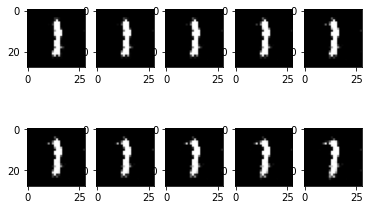

In [10]:
fig,axs= plt.subplots(2,5)
axs[0,0].imshow(gen_imgs[0, :,:,0], cmap='gray')
axs[0,1].imshow(gen_imgs[1, :,:,0], cmap='gray')
axs[0,2].imshow(gen_imgs[2, :,:,0], cmap='gray')
axs[0,3].imshow(gen_imgs[3, :,:,0], cmap='gray')
axs[0,4].imshow(gen_imgs[4, :,:,0], cmap='gray')
axs[1,0].imshow(gen_imgs[5, :,:,0], cmap='gray')
axs[1,1].imshow(gen_imgs[6, :,:,0], cmap='gray')
axs[1,2].imshow(gen_imgs[7, :,:,0], cmap='gray')
axs[1,3].imshow(gen_imgs[8, :,:,0], cmap='gray')
axs[1,4].imshow(gen_imgs[9, :,:,0], cmap='gray')
plt.show()

__Question__ Do the intermediate results always look like valid numbers ? If this is not the case, then what explanation do you have for this ?

* No this is not the case, the generators needs some iterations to become able to generate fake images that the discriminator can't detect.

__Answer__

# Training on CIFAR

Use the above code and modify it to carry out the GAN training on the CIFAR10 database.

For this case, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - BatchNormalization, momentum=0.8
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2DTranspose, filters=16,kernel size=(5,5), strides=(2,2),padding=same
  - %size = $8\times 8\times 16$
  - BatchNormalization, momentum=0.8
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2DTranspose, filters=16,kernel size=(4,4), strides=(2,2),padding=same
  - %size=$16 \times 16 \times 16$
  - BatchNormalization, momentum=0.8
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2DTranspose, filters=32,kernel size=(5,5), strides=(2,2),padding=same
  - %size = $32 \times 32 \times 32$
  - BatchNormalization, momentum=0.8
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, filters=3,kernel size=(5,5), strides=(1,1),padding=same
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer, to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. __Do not worry too much about the quality of the output images__, to get good results, longer training is usually required.

In [11]:
def build_generator(z_dim,img_shape,dataset_name):

  z_rand = Input(shape=(z_dim,))
  # BEGIN FILL IN CODE
  x=Dense( 1024,) (z_rand)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Reshape((4,4,64) ) (x)
  x=Conv2DTranspose(16,kernel_size=5,padding='same',strides=(2,2))(x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Conv2DTranspose(16,kernel_size=4,padding='same',strides=(2,2)) (x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Conv2DTranspose (32,kernel_size=5,padding='same',strides=(2,2)) (x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Conv2D (3,kernel_size=5,padding='same',strides=(1,1)) (x)
  output_img = tf.keras.activations.tanh(x)
  # END FILL IN CODE
  model_generator = Model(z_rand, output_img)
  model_generator.summary()

  return model_generator


In [12]:

def build_discriminator(img_shape,dataset_name):

  input_img = Input(shape=img_shape)
	
  # BEGIN FILL IN CODE
  
  x=Conv2D(32,kernel_size=3,padding='same',strides=(1,1)) (input_img)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(32,kernel_size=3,padding='same',strides=(2,2)) (x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(64,kernel_size=3,padding='same',strides=(2,2)) (x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(32,kernel_size=3,padding='same',strides=(2,2))(x)
  x=BatchNormalization(momentum=0.8) (x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Flatten()(x)
  p_true=Dense(1,activation='sigmoid') (x)

  

  # END FILL IN CODE

  model_discriminator=Model(input_img, p_true)
  model_discriminator.summary()

  return model_discriminator


In [13]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = np.random.normal(0, 1, (r * c, z_dim))
  gen_imgs = generator.predict(z_random)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        axs[i,j].imshow(gen_imgs[cnt, :,:])
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

In [14]:

optimizer = Adam(0.0002, 0.5)
dataset_name = 'cifar'
X_train = load_data(dataset_name)

# default parameters for cifar 
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
img_channels = X_train.shape[3]
img_shape = (img_rows, img_cols, img_channels)
z_dim = 10

# Build and compile the discriminator
discriminator = build_discriminator(img_shape,dataset_name)
# set discriminator loss
discriminator.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy']) # FILL IN CODE

# Build the generator
generator = build_generator(z_dim,img_shape,dataset_name)

# Create the stacked model
#first, create the random vector z in the latent space
z = Input(shape=(z_dim,))
#create generated (fake) image
gen_img = generator(z)  # FILL IN CODE

#indicate that for the stacked model, the weights are not trained (we only train the generator in the stacked model)
discriminator.trainable = False

# The discriminator takes generated images as input and gives a probability of whether it is a true or false image
p_true = discriminator(gen_img)  # FILL IN CODE

# The combined model  (stacked generator and discriminator)
# In this model, we train the generator only
stacked_gen_disc = Model(z, p_true)

# generator loss
generator_loss = K.mean(K.log(1-p_true))  # FILL IN CODE
# create stacked model loss
stacked_gen_disc.add_loss(generator_loss)
stacked_gen_disc.compile(optimizer=optimizer)

	

170508288/170498071 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128

In [15]:
# parameters for training
batch_size=64
n_iters_outer=10000
sample_interval=100
n_iters_inner=1	#number of internal loops

#load dataset
X_train = load_data(dataset_name)

# Adversarial ground truths
d_output_true = np.ones((batch_size,1))  #FILL IN CODE
d_output_false = np.zeros((batch_size,1)) #FILL IN CODE

# start training 
for iter_outer in range(0,n_iters_outer):

  # ---------------------
  #  Train Discriminator
  # ---------------------

  # Train the discriminator
  for iter_inner in range(0,n_iters_inner):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z_random = np.random.normal(0, 1, (batch_size, z_dim))

    # Generate a batch of new (fake) images
    gen_imgs = generator.predict(z_random)
    #print(gen_imgs)
    d_loss_real = discriminator.train_on_batch(imgs, d_output_true)  # FILL IN CODE
    d_loss_fake = discriminator.train_on_batch(gen_imgs, d_output_false) # FILL IN CODE
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  # ---------------------
  #  Train Generator
  # ---------------------


  z_random = np.random.normal(0, 1, (batch_size, z_dim))

  # Generator training : try to make generated images be classified as true by the discriminator
  g_loss = stacked_gen_disc.train_on_batch(z_random)

  # Save some random generated images and the models at every sample_interval iterations
  if (iter_outer % sample_interval == 0):
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter_outer, d_loss[0], 100*d_loss[1], g_loss))
    sample_images(generator,z_dim, rand_seed=30)

Output hidden; open in https://colab.research.google.com to view.